In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [24]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}


In [ ]:
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485,0.456,0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

### Create custom dataset

In [25]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomAniamlDataset(Dataset):
    def __init__(self,root,transforms=None):
        self.samples=[]
        self.transforms=transforms
        self.translate=translate
        self.classes = sorted(set(self.translate.values()))
        self.class_to_idx = {cls: i for i, cls in enumerate(set(translate.values()))}
        for folder in os.listdir(root):
            if folder not in translate:
                continue

            label_name = translate[folder]
            label_idx = self.class_to_idx[label_name]

            folder_path = os.path.join(root, folder)
            for file in os.listdir(folder_path):
                self.samples.append(
                    (os.path.join(folder_path, file), label_idx)
                )
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        return image, label
        

In [26]:
dataset = CustomAniamlDataset("/home/sachchida/gitrepo/Deeplearning/data/animal-img", transforms=None)

print("Total images:", len(dataset))
print("Classes:", dataset.classes)

img, label = dataset[0]
print("Label index:", label)
print("Label name:", dataset.classes[label])

Total images: 21358
Classes: ['butterfly', 'cane', 'cat', 'chicken', 'cow', 'dog', 'elefante', 'elephant', 'farfalla', 'gallina', 'gatto', 'horse', 'mucca', 'ragno', 'scoiattolo', 'sheep', 'squirrel']
Label index: 9
Label name: gallina


In [19]:
len(dataset.classes)

17

In [27]:
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = CustomAniamlDataset("/home/sachchida/gitrepo/Deeplearning/data/animal-img", transforms=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
n = 0

for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n += batch_size

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.5086, 0.4933, 0.4086])
Std: tensor([0.2213, 0.2204, 0.2234])


In [28]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size


In [29]:
from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)


In [30]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

test_transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])


In [31]:
train_dataset.dataset.transforms= train_transform
val_dataset.dataset.transforms   = test_transform
test_dataset.dataset.transforms  = test_transform

In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

img, label = train_dataset[0]
print(img.shape, label)

Train size: 14950
Val size: 3203
Test size: 3205
torch.Size([3, 224, 224]) 1


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 28x28
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [35]:
import torch.optim as optim
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CustomCNN(len(dataset.classes)).to(device=device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

criterion=nn.CrossEntropyLoss()

def train(model,loader):
    model.train()
    total_loss=0
    for images,labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(loader)

In [36]:
def evaluate(model,loader):
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for images,labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs=model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [39]:
epochs = 15
train_losses = []
test_accuracies = []
for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    train_losses.append(loss)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Test Acc: {acc:.2f}%")

Epoch 1/15 | Loss: 1.5316 | Test Acc: 49.17%
Epoch 2/15 | Loss: 1.5104 | Test Acc: 50.70%
Epoch 3/15 | Loss: 1.4647 | Test Acc: 51.01%
Epoch 4/15 | Loss: 1.4463 | Test Acc: 52.73%
Epoch 5/15 | Loss: 1.4032 | Test Acc: 50.55%
Epoch 6/15 | Loss: 1.3991 | Test Acc: 51.79%
Epoch 7/15 | Loss: 1.3757 | Test Acc: 55.04%
Epoch 8/15 | Loss: 1.3695 | Test Acc: 55.38%
Epoch 9/15 | Loss: 1.3394 | Test Acc: 54.29%
Epoch 10/15 | Loss: 1.2998 | Test Acc: 54.38%
Epoch 11/15 | Loss: 1.2678 | Test Acc: 56.66%
Epoch 12/15 | Loss: 1.2313 | Test Acc: 57.66%
Epoch 13/15 | Loss: 1.1834 | Test Acc: 56.69%
Epoch 14/15 | Loss: 1.1495 | Test Acc: 56.51%
Epoch 15/15 | Loss: 1.1332 | Test Acc: 59.22%


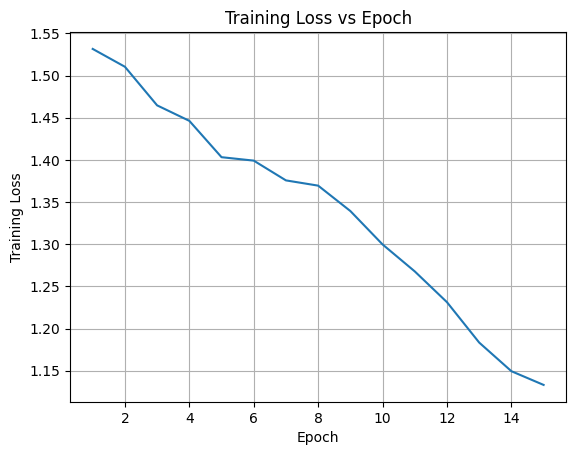

In [40]:
plt.figure()
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.show()


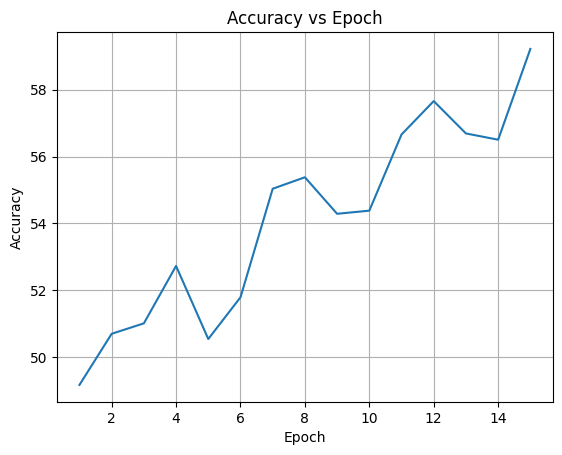

In [41]:
plt.figure()
plt.plot(range(1, epochs + 1), test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.grid(True)
plt.show()

In [42]:
import torch

def predict_image(model, image_tensor, device):
    """
    image_tensor: shape [3, 32, 32] (already transformed)
    """
    model.eval()

    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dim
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



In [43]:
import matplotlib.pyplot as plt

def denormalize(img):
    #Mean: tensor([0.5086, 0.4933, 0.4086])
    ##Std: tensor([0.2213, 0.2204, 0.2234])
    mean = torch.tensor([0.5086, 0.4933, 0.4086]).view(3,1,1)
    std  = torch.tensor([0.2213, 0.2204, 0.2234]).view(3,1,1)
    img = img * std + mean
    return img.clamp(0, 1)

In [49]:
import random
import matplotlib.pyplot as plt

def show_predictions(model, dataset, device, n=5):
    model.eval()

    classes = dataset.dataset.classes  # ✅ access underlying dataset

    plt.figure(figsize=(20, 8))

    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Predict
        with torch.no_grad():
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred_idx = output.argmax(dim=1).item()

        # Convert indices to names
        true_label = classes[label]
        pred_label = classes[pred_idx]

        # De-normalize for display
        image = denormalize(image)
        image = image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")

    plt.show()


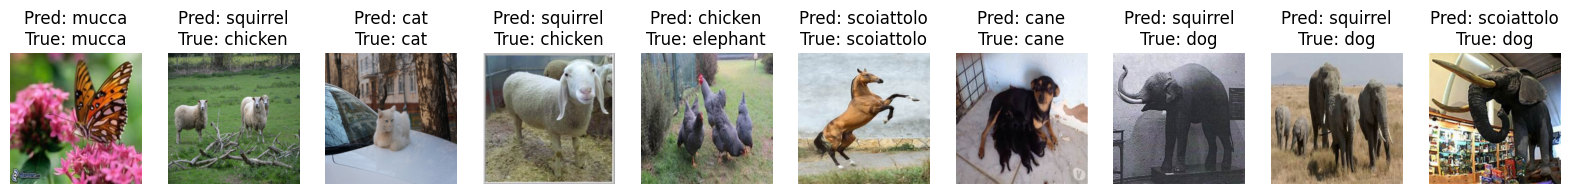

In [50]:
show_predictions(model, test_dataset, device, n=10)

## Lot of data itself is misclassified

### Train with transfer learning (ResNet18)